In [28]:
import numpy as np
import pandas as pd
import gc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from functools import partial

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

from bo_parameters import *

In [29]:
classificators = [
    ("TABNETClassifier", TabNetClassifier, SEARCH_SPACE_TABNET, TABNET_PARAMS),
    ("XGBClassifier", XGBClassifier, SEARCH_SPACE_XGB, XGBOOST_PARAMS),
    ("LGBMClassifier", LGBMClassifier, SEARCH_SPACE_LGBM, LIGHTGBM_PARAMS),
]

In [30]:
def BayesianOptimization(clf, params, search_range, model_name):
    def func_gb(values):
        for i, param in enumerate(search_range):
            params[param.name] = values[i]
            if param.name == "n_a":
                params["n_d"] = values[i]
        print('\nTesting next set of paramaters...', params)

        model = clf(**params)
        model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric=["auc"], early_stopping_rounds=10, verbose=0)
        neg_auc = round(-roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1]), 6)

        print('AUC: ', -neg_auc, ' of boosting iteration ')
        return neg_auc
    
    def func_tabnet(values):
        for i, param in enumerate(search_range):
            params[param.name] = values[i]
            if param.name == "n_a":
                params["n_d"] = values[i]
        print('\nTesting next set of paramaters...', params)

        model = clf(**params)
        model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric=["auc"], max_epochs=40)
        neg_auc = round(-roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1]), 6)

        print('AUC: ', -neg_auc, ' of boosting iteration ')
        return neg_auc
    
    return func_gb if model_name != "TABNETClassifier" else func_tabnet

In [31]:
datasets = ["appetency", "churn", "upselling"]

In [32]:
for dataset in datasets[:1]:
    train = pd.read_csv("data/kdd/small/{}/train.csv".format(dataset))
    valid = pd.read_csv("data/kdd/small/{}/val.csv".format(dataset))
    
    train_x = train.drop(["TARGET"], axis=1).values
    train_y = train["TARGET"].values
    
    valid_x = valid.drop(["TARGET"], axis=1).values
    valid_y = valid["TARGET"].values

    results = dict()
    for clf_name, clf, search_range, params in classificators:
        res_gp = gp_minimize(BayesianOptimization(clf, params, search_range, clf_name), search_range, n_jobs=-1, verbose=True, n_random_starts=10, n_calls=30)
        results[clf_name] = res_gp
        with open('{}_hp_kdd_{}.pickle'.format(clf_name, dataset), 'wb') as f:
            pickle.dump(res_gp.x, f)

Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'seed': 42, 'verbose': True, 'gamma': 1.2983401976418565, 'lambda_sparse': 0.036534007757701534, 'n_steps': 4, 'n_a': 24, 'n_d': 24, 'momentum': 0.8}
Device used : cpu
epoch 0  | loss: 0.20132 | val_0_auc: 0.52781 |  0:00:14s
epoch 1  | loss: 0.14292 | val_0_auc: 0.55656 |  0:00:28s
epoch 2  | loss: 0.11334 | val_0_auc: 0.50093 |  0:00:42s
epoch 3  | loss: 0.10378 | val_0_auc: 0.51211 |  0:00:56s
epoch 4  | loss: 0.09904 | val_0_auc: 0.48887 |  0:01:10s
epoch 5  | loss: 0.09495 | val_0_auc: 0.55913 |  0:01:23s
epoch 6  | loss: 0.09475 | val_0_auc: 0.52865 |  0:01:37s
epoch 7  | loss: 0.09408 | val_0_auc: 0.57013 |  0:01:50s
epoch 8  | loss: 0.09513 | val_0_auc: 0.50221 |  0:02:04s
epoch 9  | loss: 0.09279 | val_0_auc: 0.55148 |  0:02:17s
epoch 10 | loss: 0.09323 | val_0_auc: 0.52589 |  0:02:30s
epoch 11 | loss: 0.0925  | val_0_auc: 0.54843 |  0:02:44s
epoch 12 | loss: 0.09296 | val_0_auc: 

epoch 22 | loss: 0.08414 | val_0_auc: 0.7782  |  0:06:42s
epoch 23 | loss: 0.08307 | val_0_auc: 0.77648 |  0:06:59s
epoch 24 | loss: 0.08384 | val_0_auc: 0.78087 |  0:07:15s
epoch 25 | loss: 0.08378 | val_0_auc: 0.77309 |  0:07:32s
epoch 26 | loss: 0.08314 | val_0_auc: 0.78238 |  0:07:49s
epoch 27 | loss: 0.08301 | val_0_auc: 0.78961 |  0:08:06s
epoch 28 | loss: 0.08273 | val_0_auc: 0.79659 |  0:08:22s
epoch 29 | loss: 0.08277 | val_0_auc: 0.80488 |  0:08:38s
epoch 30 | loss: 0.08219 | val_0_auc: 0.80675 |  0:08:55s
epoch 31 | loss: 0.08188 | val_0_auc: 0.80714 |  0:09:11s
epoch 32 | loss: 0.08193 | val_0_auc: 0.80461 |  0:09:28s
epoch 33 | loss: 0.08213 | val_0_auc: 0.80276 |  0:09:44s
epoch 34 | loss: 0.08371 | val_0_auc: 0.80629 |  0:10:00s
epoch 35 | loss: 0.08294 | val_0_auc: 0.79493 |  0:10:17s
epoch 36 | loss: 0.08215 | val_0_auc: 0.80531 |  0:10:34s
epoch 37 | loss: 0.08167 | val_0_auc: 0.81043 |  0:10:51s
epoch 38 | loss: 0.08165 | val_0_auc: 0.79308 |  0:11:07s
epoch 39 | los

epoch 20 | loss: 0.07961 | val_0_auc: 0.79162 |  0:03:53s
epoch 21 | loss: 0.07955 | val_0_auc: 0.79325 |  0:04:04s
epoch 22 | loss: 0.07963 | val_0_auc: 0.7921  |  0:04:14s
epoch 23 | loss: 0.07974 | val_0_auc: 0.79449 |  0:04:25s
epoch 24 | loss: 0.0803  | val_0_auc: 0.78576 |  0:04:36s
epoch 25 | loss: 0.07987 | val_0_auc: 0.80037 |  0:04:46s
epoch 26 | loss: 0.07925 | val_0_auc: 0.79681 |  0:04:57s
epoch 27 | loss: 0.07918 | val_0_auc: 0.78039 |  0:05:07s
epoch 28 | loss: 0.07917 | val_0_auc: 0.79226 |  0:05:18s
epoch 29 | loss: 0.07916 | val_0_auc: 0.79688 |  0:05:29s
epoch 30 | loss: 0.079   | val_0_auc: 0.7981  |  0:05:39s
epoch 31 | loss: 0.07904 | val_0_auc: 0.79385 |  0:05:50s
epoch 32 | loss: 0.07893 | val_0_auc: 0.7841  |  0:06:00s
epoch 33 | loss: 0.07922 | val_0_auc: 0.79851 |  0:06:11s
epoch 34 | loss: 0.07919 | val_0_auc: 0.79874 |  0:06:22s
epoch 35 | loss: 0.07893 | val_0_auc: 0.79128 |  0:06:32s

Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0

epoch 9  | loss: 0.08056 | val_0_auc: 0.82436 |  0:02:14s
epoch 10 | loss: 0.08036 | val_0_auc: 0.81959 |  0:02:28s
epoch 11 | loss: 0.08005 | val_0_auc: 0.80545 |  0:02:41s
epoch 12 | loss: 0.07864 | val_0_auc: 0.81474 |  0:02:55s
epoch 13 | loss: 0.07901 | val_0_auc: 0.81939 |  0:03:08s
epoch 14 | loss: 0.0793  | val_0_auc: 0.81291 |  0:03:21s
epoch 15 | loss: 0.07971 | val_0_auc: 0.81812 |  0:03:35s
epoch 16 | loss: 0.07831 | val_0_auc: 0.82741 |  0:03:48s
epoch 17 | loss: 0.07848 | val_0_auc: 0.82301 |  0:04:02s
epoch 18 | loss: 0.07779 | val_0_auc: 0.82373 |  0:04:15s
epoch 19 | loss: 0.07836 | val_0_auc: 0.82674 |  0:04:28s
epoch 20 | loss: 0.07756 | val_0_auc: 0.81751 |  0:04:42s
epoch 21 | loss: 0.07748 | val_0_auc: 0.81965 |  0:04:55s
epoch 22 | loss: 0.07782 | val_0_auc: 0.80211 |  0:05:10s
epoch 23 | loss: 0.07768 | val_0_auc: 0.81191 |  0:05:23s
epoch 24 | loss: 0.07729 | val_0_auc: 0.81454 |  0:05:37s
epoch 25 | loss: 0.07697 | val_0_auc: 0.81324 |  0:05:50s
epoch 26 | los

epoch 0  | loss: 0.29926 | val_0_auc: 0.47195 |  0:00:19s
epoch 1  | loss: 0.19936 | val_0_auc: 0.51221 |  0:00:38s
epoch 2  | loss: 0.15886 | val_0_auc: 0.48714 |  0:00:57s
epoch 3  | loss: 0.1319  | val_0_auc: 0.4909  |  0:01:15s
epoch 4  | loss: 0.10452 | val_0_auc: 0.55639 |  0:01:33s
epoch 5  | loss: 0.0975  | val_0_auc: 0.4834  |  0:01:51s
epoch 6  | loss: 0.09826 | val_0_auc: 0.60486 |  0:02:09s
epoch 7  | loss: 0.09567 | val_0_auc: 0.54333 |  0:02:26s
epoch 8  | loss: 0.09654 | val_0_auc: 0.56078 |  0:02:44s
epoch 9  | loss: 0.09535 | val_0_auc: 0.58827 |  0:03:02s
epoch 10 | loss: 0.09508 | val_0_auc: 0.59333 |  0:03:19s
epoch 11 | loss: 0.0949  | val_0_auc: 0.5505  |  0:03:37s
epoch 12 | loss: 0.09305 | val_0_auc: 0.62585 |  0:03:54s
epoch 13 | loss: 0.09231 | val_0_auc: 0.62604 |  0:04:12s
epoch 14 | loss: 0.09071 | val_0_auc: 0.61616 |  0:04:29s
epoch 15 | loss: 0.09147 | val_0_auc: 0.60645 |  0:04:47s
epoch 16 | loss: 0.09195 | val_0_auc: 0.61167 |  0:05:05s
epoch 17 | los

epoch 9  | loss: 0.09042 | val_0_auc: 0.66852 |  0:03:29s
epoch 10 | loss: 0.09203 | val_0_auc: 0.67662 |  0:03:49s
epoch 11 | loss: 0.0955  | val_0_auc: 0.68604 |  0:04:10s
epoch 12 | loss: 0.09071 | val_0_auc: 0.71687 |  0:04:30s
epoch 13 | loss: 0.09026 | val_0_auc: 0.7105  |  0:04:50s
epoch 14 | loss: 0.08824 | val_0_auc: 0.73679 |  0:05:12s
epoch 15 | loss: 0.08862 | val_0_auc: 0.72489 |  0:05:32s
epoch 16 | loss: 0.08891 | val_0_auc: 0.69861 |  0:05:51s
epoch 17 | loss: 0.08823 | val_0_auc: 0.69575 |  0:06:11s
epoch 18 | loss: 0.08748 | val_0_auc: 0.69407 |  0:06:31s
epoch 19 | loss: 0.08706 | val_0_auc: 0.73726 |  0:06:51s
epoch 20 | loss: 0.08684 | val_0_auc: 0.68763 |  0:07:11s
epoch 21 | loss: 0.08781 | val_0_auc: 0.69055 |  0:07:31s
epoch 22 | loss: 0.08641 | val_0_auc: 0.69627 |  0:07:51s
epoch 23 | loss: 0.08631 | val_0_auc: 0.70564 |  0:08:11s
epoch 24 | loss: 0.08677 | val_0_auc: 0.7062  |  0:08:31s
epoch 25 | loss: 0.08623 | val_0_auc: 0.69034 |  0:08:51s
epoch 26 | los

epoch 8  | loss: 0.08951 | val_0_auc: 0.69458 |  0:03:59s
epoch 9  | loss: 0.08864 | val_0_auc: 0.73523 |  0:04:25s
epoch 10 | loss: 0.08705 | val_0_auc: 0.72185 |  0:04:51s
epoch 11 | loss: 0.08592 | val_0_auc: 0.7352  |  0:05:19s
epoch 12 | loss: 0.08611 | val_0_auc: 0.72879 |  0:05:45s
epoch 13 | loss: 0.08644 | val_0_auc: 0.72705 |  0:06:11s
epoch 14 | loss: 0.08622 | val_0_auc: 0.69933 |  0:06:38s
epoch 15 | loss: 0.08733 | val_0_auc: 0.737   |  0:07:04s
epoch 16 | loss: 0.0867  | val_0_auc: 0.7293  |  0:07:31s
epoch 17 | loss: 0.08664 | val_0_auc: 0.72131 |  0:07:57s
epoch 18 | loss: 0.08663 | val_0_auc: 0.72655 |  0:08:24s
epoch 19 | loss: 0.08541 | val_0_auc: 0.78095 |  0:08:49s
epoch 20 | loss: 0.08585 | val_0_auc: 0.69798 |  0:09:15s
epoch 21 | loss: 0.08575 | val_0_auc: 0.77956 |  0:09:42s
epoch 22 | loss: 0.08478 | val_0_auc: 0.78973 |  0:10:07s
epoch 23 | loss: 0.08234 | val_0_auc: 0.79084 |  0:10:33s
epoch 24 | loss: 0.08039 | val_0_auc: 0.79796 |  0:10:59s
epoch 25 | los

epoch 23 | loss: 0.09173 | val_0_auc: 0.52577 |  0:06:10s
epoch 24 | loss: 0.09102 | val_0_auc: 0.47925 |  0:06:24s
epoch 25 | loss: 0.09013 | val_0_auc: 0.60778 |  0:06:40s
epoch 26 | loss: 0.08837 | val_0_auc: 0.62205 |  0:06:55s
epoch 27 | loss: 0.08825 | val_0_auc: 0.60964 |  0:07:10s
epoch 28 | loss: 0.08829 | val_0_auc: 0.6284  |  0:07:26s
epoch 29 | loss: 0.08859 | val_0_auc: 0.61878 |  0:07:41s
epoch 30 | loss: 0.08821 | val_0_auc: 0.61985 |  0:07:56s
epoch 31 | loss: 0.08814 | val_0_auc: 0.62361 |  0:08:11s
epoch 32 | loss: 0.08747 | val_0_auc: 0.61149 |  0:08:27s
epoch 33 | loss: 0.08789 | val_0_auc: 0.62047 |  0:08:42s
epoch 34 | loss: 0.08754 | val_0_auc: 0.62428 |  0:08:57s
epoch 35 | loss: 0.08813 | val_0_auc: 0.64528 |  0:09:12s
epoch 36 | loss: 0.08826 | val_0_auc: 0.62887 |  0:09:28s
epoch 37 | loss: 0.08775 | val_0_auc: 0.6257  |  0:09:43s
epoch 38 | loss: 0.08779 | val_0_auc: 0.61481 |  0:09:58s
epoch 39 | loss: 0.08828 | val_0_auc: 0.62751 |  0:10:14s
Stop training 

epoch 22 | loss: 0.08075 | val_0_auc: 0.80136 |  0:09:27s
epoch 23 | loss: 0.07988 | val_0_auc: 0.78813 |  0:09:52s
epoch 24 | loss: 0.07976 | val_0_auc: 0.80002 |  0:10:16s
epoch 25 | loss: 0.07987 | val_0_auc: 0.78384 |  0:10:41s
epoch 26 | loss: 0.07978 | val_0_auc: 0.79068 |  0:11:05s
epoch 27 | loss: 0.07988 | val_0_auc: 0.79075 |  0:11:30s
epoch 28 | loss: 0.0803  | val_0_auc: 0.7919  |  0:11:54s
epoch 29 | loss: 0.08076 | val_0_auc: 0.79277 |  0:12:19s
epoch 30 | loss: 0.07936 | val_0_auc: 0.79562 |  0:12:43s
epoch 31 | loss: 0.07921 | val_0_auc: 0.78753 |  0:13:07s
epoch 32 | loss: 0.0796  | val_0_auc: 0.79947 |  0:13:32s

Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_auc = 0.80136
Best weights from best epoch are automatically used!
AUC:  0.801358  of boosting iteration 
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 828.3928
Function value obtained: -0.8014
Current minimum: -0.8429
Iteration No: 1 started. Evaluating 

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:06] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.835855  of boosting iteration 
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3568
Function value obtained: -0.8359
Current minimum: -0.8359
Iteration No: 2 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6406746302524544, 'max_depth': 4, 'n_estimators': 775}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:08] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.850239  of boosting iteration 
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.2226
Function value obtained: -0.8502
Current minimum: -0.8502
Iteration No: 3 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.43493507074037885, 'max_depth': 14, 'n_estimators': 346}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:09] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.828321  of boosting iteration 
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.3734
Function value obtained: -0.8283
Current minimum: -0.8502
Iteration No: 4 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.5803025792095959, 'max_depth': 6, 'n_estimators': 374}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:12] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.850169  of boosting iteration 
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.5647
Function value obtained: -0.8502
Current minimum: -0.8502
Iteration No: 5 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.7986776480109528, 'max_depth': 4, 'n_estimators': 271}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:14] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.849362  of boosting iteration 
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.1152
Function value obtained: -0.8494
Current minimum: -0.8502
Iteration No: 6 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.8711397534666082, 'max_depth': 11, 'n_estimators': 481}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:15] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.83574  of boosting iteration 
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 2.0025
Function value obtained: -0.8357
Current minimum: -0.8502
Iteration No: 7 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4230006612423386, 'max_depth': 6, 'n_estimators': 836}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:17] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.850149  of boosting iteration 
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 1.7896
Function value obtained: -0.8501
Current minimum: -0.8502
Iteration No: 8 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9825771685560655, 'max_depth': 9, 'n_estimators': 760}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:19] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.829305  of boosting iteration 
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 1.6966
Function value obtained: -0.8293
Current minimum: -0.8502
Iteration No: 9 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.4451344632234332, 'max_depth': 14, 'n_estimators': 385}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:20] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.82534  of boosting iteration 
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 2.5357
Function value obtained: -0.8253
Current minimum: -0.8502
Iteration No: 10 started. Evaluating function at random point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.26051186699738493, 'max_depth': 7, 'n_estimators': 970}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:23] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.846654  of boosting iteration 
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 3.0303
Function value obtained: -0.8467
Current minimum: -0.8502
Iteration No: 11 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 315}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.853213  of boosting iteration 
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 3.2961
Function value obtained: -0.8532
Current minimum: -0.8532
Iteration No: 12 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 183}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:29] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.854788  of boosting iteration 
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 3.3220
Function value obtained: -0.8548
Current minimum: -0.8548
Iteration No: 13 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 183}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:32] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.846496  of boosting iteration 
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 2.4702
Function value obtained: -0.8465
Current minimum: -0.8548
Iteration No: 14 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 795}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:35] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.854788  of boosting iteration 
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 3.3480
Function value obtained: -0.8548
Current minimum: -0.8548
Iteration No: 15 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.10186000058897077, 'max_depth': 10, 'n_estimators': 685}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:38] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.843389  of boosting iteration 
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 5.3744
Function value obtained: -0.8434
Current minimum: -0.8548
Iteration No: 16 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9987613472955277, 'max_depth': 3, 'n_estimators': 541}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:44] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.83951  of boosting iteration 
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.2090
Function value obtained: -0.8395
Current minimum: -0.8548
Iteration No: 17 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.10024305903331414, 'max_depth': 12, 'n_estimators': 264}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:45] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.843592  of boosting iteration 
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 6.3380
Function value obtained: -0.8436
Current minimum: -0.8548
Iteration No: 18 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9972848130630817, 'max_depth': 5, 'n_estimators': 372}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:51] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.841974  of boosting iteration 
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1.6172
Function value obtained: -0.8420
Current minimum: -0.8548
Iteration No: 19 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9993524174904217, 'max_depth': 15, 'n_estimators': 983}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:53] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.799359  of boosting iteration 
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 2.6957
Function value obtained: -0.7994
Current minimum: -0.8548
Iteration No: 20 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.10274680533431585, 'max_depth': 15, 'n_estimators': 778}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:45:56] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.832256  of boosting iteration 
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 5.7401
Function value obtained: -0.8323
Current minimum: -0.8548
Iteration No: 21 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.10342167415775995, 'max_depth': 6, 'n_estimators': 164}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:46:01] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.852185  of boosting iteration 
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 4.3559
Function value obtained: -0.8522
Current minimum: -0.8548
Iteration No: 22 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.31662208106372236, 'max_depth': 5, 'n_estimators': 100}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:46:06] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.849596  of boosting iteration 
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 2.2197
Function value obtained: -0.8496
Current minimum: -0.8548
Iteration No: 23 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.49253301287854145, 'max_depth': 10, 'n_estimators': 247}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:46:08] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.827073  of boosting iteration 
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.2904
Function value obtained: -0.8271
Current minimum: -0.8548
Iteration No: 24 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.47733572147192493, 'max_depth': 3, 'n_estimators': 161}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:46:10] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.841074  of boosting iteration 
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 1.4101
Function value obtained: -0.8411
Current minimum: -0.8548
Iteration No: 25 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:46:12] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.854788  of boosting iteration 
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 3.3756
Function value obtained: -0.8548
Current minimum: -0.8548
Iteration No: 26 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.10146816775858006, 'max_depth': 8, 'n_estimators': 750}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:46:15] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.854454  of boosting iteration 
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 6.4897
Function value obtained: -0.8545
Current minimum: -0.8548
Iteration No: 27 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.6475566411069852, 'max_depth': 5, 'n_estimators': 1000}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:46:21] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.853748  of boosting iteration 
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.6280
Function value obtained: -0.8537
Current minimum: -0.8548
Iteration No: 28 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.9999103885253068, 'max_depth': 12, 'n_estimators': 249}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:46:23] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.811313  of boosting iteration 
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 2.4512
Function value obtained: -0.8113
Current minimum: -0.8548
Iteration No: 29 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.7178786193852936, 'max_depth': 8, 'n_estimators': 215}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:46:25] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.832592  of boosting iteration 
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.9013
Function value obtained: -0.8326
Current minimum: -0.8548
Iteration No: 30 started. Searching for the next optimal point.

Testing next set of paramaters... {'booster': 'gbtree', 'objective': 'binary:logistic', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.3370675014731547, 'max_depth': 12, 'n_estimators': 936}


/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:46:27] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC:  0.839254  of boosting iteration 
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 3.4167
Function value obtained: -0.8393
Current minimum: -0.8548
Iteration No: 1 started. Evaluating function at random point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.29470302886859817, 'max_depth': 4, 'n_estimators': 689}
AUC:  0.836335  of boosting iteration 
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.6439
Function value obtained: -0.8363
Current minimum: -0.8363
Iteration No: 2 started. Evalu

AUC:  0.851165  of boosting iteration 
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.9832
Function value obtained: -0.8512
Current minimum: -0.8550
Iteration No: 16 started. Searching for the next optimal point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 109}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  0.843622  of boosting iteration 
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.0019
Function value obtained: -0.8436
Current minimum: -0.8550
Iteration No: 17 started. Searching for the next optimal point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rat

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


AUC:  0.851165  of boosting iteration 
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 1.0295
Function value obtained: -0.8512
Current minimum: -0.8550
Iteration No: 20 started. Searching for the next optimal point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1880617274662131, 'max_depth': 6, 'n_estimators': 109}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  0.843158  of boosting iteration 
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.0198
Function value obtained: -0.8432
Current minimum: -0.8550
Iteration No: 21 started. Searching for the next optimal point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True

/home/marinamandarina_07/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


AUC:  0.851165  of boosting iteration 
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.0433
Function value obtained: -0.8512
Current minimum: -0.8550
Iteration No: 29 started. Searching for the next optimal point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 417}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC:  0.853088  of boosting iteration 
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.1472
Function value obtained: -0.8531
Current minimum: -0.8550
Iteration No: 30 started. Searching for the next optimal point.

Testing next set of paramaters... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'random_state': 42, 'silent': True, 'learning_rat

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

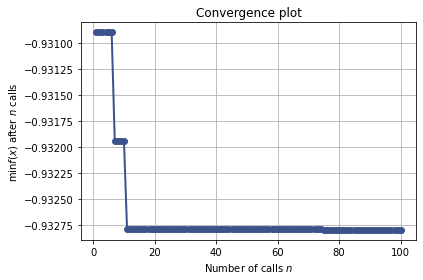

In [14]:
plot_convergence(results["LGBMClassifier"])

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

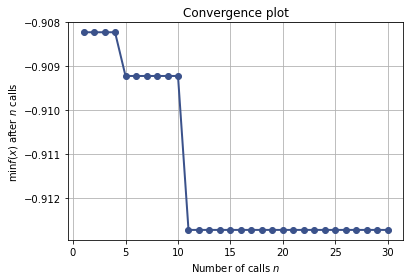

In [15]:
plot_convergence(results["TABNETClassifier"])

In [15]:
results["LGBMClassifier"].x

[0.10284216487315759, 4, 955]

In [16]:
results["XGBClassifier"].x

[0.3317433223693123, 4, 772]

In [16]:
results["TABNETClassifier"].x

[1.0131059206061017, 0.0051151725754103195, 10, 54]

In [33]:
for dataset in datasets:
    print("Dataset:", dataset)
    for classifier in classificators:
        with open("{}_hp_kdd_{}.pickle".format(classifier[0], dataset), "rb") as f:
            params = pickle.load(f)
            print('\t' + classifier[0], params)

Dataset: appetency
	TABNETClassifier [1.2917828325804677, 0.0001, 3, 8, 0.98]
	XGBClassifier [0.1, 5, 183]
	LGBMClassifier [0.1, 4, 361]
Dataset: churn
	TABNETClassifier [1.0, 0.001, 3, 8]
	XGBClassifier [0.10258423586932192, 3, 212]
	LGBMClassifier [0.10090558417844547, 3, 289]
Dataset: upselling
	TABNETClassifier [1.0278804398968666, 0.060872939878532255, 3, 54]
	XGBClassifier [0.12505580158355423, 3, 978]
	LGBMClassifier [0.10056036392812367, 9, 574]
